<a href="https://colab.research.google.com/github/Malware-Analysis-Using-Grad-CAM/Project/blob/master/MalwareDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import random
import os


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Preprocessor:
    def __init__(self, api_sequences, labels):
        self.api_sequences = api_sequences
        self.labels = labels
        self.api_to_id = {'<unk>': 0}
        self.id_to_api = {0: '<unk>'}
        self.api_id_num = 1
        self.label_to_id = {}
        self.id_to_label = {}
        self.label_id_num = 0

    def api_sequnces_to_tensor(self):
        xs = []
        for api_sequnce in self.api_sequences:
            t = np.array(list(
                map(lambda x: self.api_to_id[x] if self.api_to_id.get(x) else 0, api_sequnce)), dtype='int64')
            t = torch.from_numpy(t)
            xs.append(t)
        ys = []
        for label in self.labels:
            t = np.array(
                [self.label_to_id[label]])
            t = torch.from_numpy(t)
            ys.append(t)
        return xs, ys

    def build_ids(self):
        for apis in self.api_sequences:
            for api in apis:
                if self.api_to_id.get(api) == None:
                    self.api_to_id[api] = self.api_id_num
                    self.id_to_api[self.api_id_num] = api
                    self.api_id_num += 1

        for label in self.labels:
            if self.label_to_id.get(label) == None:
                self.label_to_id[label] = self.label_id_num
                self.id_to_label[self.label_id_num] = api
                self.label_id_num += 1


In [ ]:
def load_data(benign_dir, malware_dir):
    # benign_dir = '/data/benign'

    benign_file_list = os.listdir(benign_dir)

    benign_api_seq = []
    for name in benign_file_list:
        with open(benign_dir + name, 'r', encoding='utf-8') as file:
            # file = open(benign_dir + name, 'r', encoding='utf-8')
            # print(file)
            header = True
            first_API = True
            API_SEQ = []

            for line in file:
                if header:
                    header = False
                    continue

                data = line[:-1].split(',')
                if data[3].find('Process Start') != -1:
                    line = file.readline()
                    API_SEQ.append(data[3])
                    while line.startswith(';'):
                        line = file.readline()
                data = line[:-1].split(',')

                API_SEQ.append(data[3])

        benign_api_seq.append(API_SEQ)

    # malware_dir = '/data/malware'

    malware_file_list = os.listdir(malware_dir)

    malware_api_seq = []
    for name in malware_file_list:
        with open(malware_dir + name, 'r', encoding='utf-8') as file:
            header = True
            first_API = True
            API_SEQ = []

            for line in file:
                if header:
                    header = False
                    continue

                data = line[:-1].split(',')
                if data[3].find('Process Start') != -1:
                    line = file.readline()
                    API_SEQ.append(data[3])
                    while line.startswith(';'):
                        line = file.readline()
                data = line[:-1].split(',')

                API_SEQ.append(data[3])

        malware_api_seq.append(API_SEQ)
    return benign_api_seq, malware_api_seq


In [ ]:

class ClassifierWithAttention(nn.Module):
    def __init__(self, batch_size, vocab_size, embed_size, hidden_size, output_size):
        super(ClassifierWithAttention, self).__init__()
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.lstm = nn.LSTM(
            self.embed_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.act = nn.Sigmoid()

    def attention_net(self, lstm_output, final_state):
        # hidden = final_state.squeeze(0)
        hidden = final_state.view(-1, self.hidden_size, 1)
        # attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)
        attn_weights = F.softmax(attn_weights, 1)
        attn_applied = torch.bmm(
            lstm_output.transpose(1, 2), attn_weights.unsqueeze(2)
        ).squeeze(2)
        return attn_applied, attn_weights

    def forward(self, input):
        embedded = self.embedding(input)
        embedded = embedded.permute(1, 0, 2)

        h_0 = torch.zeros(1, len(input), self.hidden_size).cuda()
        c_0 = torch.zeros(1, len(input), self.hidden_size).cuda()

        lstm_output, (hidden, cell) = self.lstm(embedded, (h_0, c_0))
        lstm_output = lstm_output.permute(1, 0, 2)

        attn_applied, attn_weights = self.attention_net(lstm_output, hidden)

        output = self.out(attn_applied)
        output = output.squeeze()
        output = self.act(output)

        return output, attn_weights

    def initHidden(self):
        return torch.zroes(1, 1, self.hidden_size, device=torch.device("cpu"))


In [ ]:
def move_to(l):
    return [i.to(device) for i in l]


def train(model, xs, ys, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    num_corrects = 0

    model.train()

    for i in range(len(xs)):
        optimizer.zero_grad()

        output, attn = model(xs[i].reshape(1, len(xs[i])))
        target = ys[i]
        target = torch.autograd.Variable(target).long()
        output = output.unsqueeze(0)
        loss = criterion(output, target)
        acc = (torch.max(output, 1)[1].view(
            target.size()).data == target.data).sum()
        num_corrects += acc

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(xs), epoch_acc / len(xs)


In [ ]:
def evaluate(model, xs, ys, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
    for i in range(len(xs)):
      prediction, attn = model(xs[i].reshape(1, len(xs[i])))
      prediction = prediction.squeeze()
      prediction = prediction.unsqueeze(0)


      target = ys[i]
      target = torch.autograd.Variable(target).long()

      loss = criterion(prediction, target)
      acc = (torch.max(prediction, 1)[1].view(
            target.size()).data == target.data).sum()
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(xs), epoch_acc / len(xs)


In [ ]:
benign_dir = "/content/gdrive/My Drive/data/BENIGN_API_SEQUENCE/"
malware_dir = "/content/gdrive/My Drive/data/MALWARE_API_SEQUENCE/"

benign_api_sequence, malware_api_sequence = load_data(benign_dir, malware_dir)

labels = ['benign' if i < len(benign_api_sequence) else 'malware' for i in range(
    len(benign_api_sequence) + len(malware_api_sequence))]


pp = Preprocessor(benign_api_sequence+malware_api_sequence, labels)

pp.build_ids()
api_sequence_tensors, label_tensors = pp.api_sequnces_to_tensor()

api_sequence_tensors = move_to(api_sequence_tensors)
label_tensors = move_to(label_tensors)

shuffle = list(zip(api_sequence_tensors, label_tensors))
random.shuffle(shuffle)
api_sequence_tensors, label_tensors = zip(*shuffle)


train_x, test_x = api_sequence_tensors[:100], api_sequence_tensors[:100]
train_y, test_y = label_tensors[:100], label_tensors[:100]


num_id = len(pp.id_to_api)
embedding_size = 100
num_hidden_nodes = 16
num_output_nodes = 2

model = ClassifierWithAttention(
    1, num_id, embedding_size, num_hidden_nodes, num_output_nodes)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

for epoch in range(3):
  train_loss, train_acc = train(model, train_x, train_y, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, test_x, test_y, criterion)

  print("epoch {}".format(epoch))
  print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
  print(f"\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%")


epoch 0
	Train Loss: 0.672 | Train Acc: 63.00%
	Valid Loss: 0.639 | Valid Acc: 72.00%
epoch 1
	Train Loss: 0.570 | Train Acc: 91.00%
	Valid Loss: 0.468 | Valid Acc: 99.00%
epoch 2
	Train Loss: 0.399 | Train Acc: 99.00%
	Valid Loss: 0.358 | Valid Acc: 100.00%


<BarContainer object of 23294 artists>

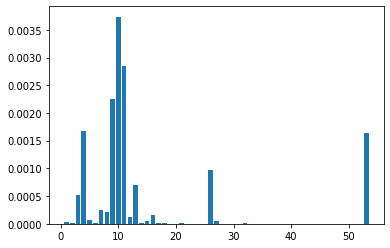

In [ ]:
import matplotlib.pyplot as plt

model.eval()

predict, attn = model(test_x[0].reshape(1, len(test_x[0])))

plt.bar(test_x[0].cpu(), attn.cpu().detach().numpy().squeeze())